<a href="https://colab.research.google.com/github/Fatimabatool16/Assignment_03-Bert-Model/blob/main/Assignment_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Assignment#03**
#Enhanced BERT Fake News Classification



Research Paper Link:
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10742347

In [ ]:
# Install required libraries
!pip install transformers datasets scikit-learn --quiet

In [ ]:
!pip install kaggle

In [ ]:
import os
import json

# Set up Kaggle API credentials
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
#/content/kaggle.json
# Make the Kaggle API key available to the environment
with open('/content/drive/MyDrive/Colab Notebooks/Copy of kaggle.json') as f:
    kaggle_json = json.load(f)
    os.environ['KAGGLE_USERNAME'] = kaggle_json['username']
    os.environ['KAGGLE_KEY'] = kaggle_json['key']

# **PolitiTweets**

In [ ]:
!kaggle datasets download -d ameerhamza123/pak-tweets --force
!unzip -o pak-tweets.zip

Dataset URL: https://www.kaggle.com/datasets/ameerhamza123/pak-tweets
License(s): unknown
  0% 0.00/170k [00:00<?, ?B/s]
100% 170k/170k [00:00<00:00, 375MB/s]
Archive:  pak-tweets.zip
  inflating: PAk_Tweets_local_data.csv  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
import pandas as pd #Data Handling(Reading/cleaning csv files)
import numpy as np #Numerical operation on array
import re #python builtin (text preprocessing)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch #core pytorch library for tensor computation & GPU acceleration
from torch import nn #provide NNlayers, loss function
from torch.utils.data import Dataset, DataLoader #custom class to wrap data & auto batches/shuffles/load data during training
from transformers import BertTokenizerFast, BertModel #huggingface transformer-> tokenize data (IDs) & pretrained model to generate embeddings
from torch.optim import AdamW #variate of Adam optimizer (L2 reguralizer)
from tqdm import tqdm #display progress bar

# **Data Cleaning**

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", '', text)          # remove URLs
    text = re.sub(r'\@[\w]+', '', text)                 # remove mentions
    text = re.sub(r'#', '', text)                       # remove hashtags
    text = re.sub(r'<.*?>', '', text)                   # remove HTML
    text = re.sub(r'[^a-zA-Z\s]', '', text)             # remove punctuation & numbers
    text = re.sub(r'\s+', ' ', text).strip()            # remove extra spaces
    return text

# **Load_PolitiTweets**

In [ ]:
# Step 1: Load and clean dataset
df = pd.read_csv("/content/PAk_Tweets_local_data.csv")
df = df.rename(columns={"text": "text", "category": "label"})
df["label"] = df["label"].map({True: 1, False: 0})
df = df.dropna(subset=["text", "label"]) #Prevents errors during tokenization/training.
df = df.sample(n=1000, random_state=42) #Reduce sample size & each time same samples

df["text"] = df["text"].apply(clean_text)

# **Tokenizing:**
Tokenizing your cleaned text using a pretrained BERT tokenizer to get input IDs and attention masks, which are required for BERT models.

In [ ]:
# Step 2: Tokenization
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.2, random_state=42)

#Truncate(short lengthy sent.), Padding(extra space for shorter sent.), token length for bert=128
train_encodings = tokenizer(list(X_train), truncation=True, padding='max_length', max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding='max_length', max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#Step 3: PyTorch Dataset
class FakeNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings #save encodings(id&mask) into self.encodings
        self.labels = labels #save labels(1/0) into self.labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'label': torch.tensor(self.labels[idx]) #torch.tensor converting for pytorch model
        }

    def __len__(self):
        return len(self.labels) #Total samples

train_dataset = FakeNewsDataset(train_encodings, list(y_train))
test_dataset = FakeNewsDataset(test_encodings, list(y_test))


# **Additional Layer Architecture**

In [ ]:
#Step 4: Model Architecture (Enhanced BERT with bottleneck)
class EnhancedBERTClassifier(nn.Module): #pyTorch Model->follow NN module

    def __init__(self):
        super().__init__() #Parent Class
        #super(EnhancedBERTClassifier, self).__init__()

        self.bert = BertModel.from_pretrained("bert-base-uncased")

        for param in self.bert.parameters(): #Fine Tuning
            param.requires_grad = True

        self.dropout = nn.Dropout(0.3) #Ignore neuron to prevent overfitting
        self.fc1 = nn.Linear(768, 768) #Dense Layer
        self.fc2 = nn.Linear(768, 128)  # Bottleneck Second Layer Compress features
        self.classifier = nn.Linear(128, 2) #Final Layer (Real/Fake)

    def forward(self, input_ids, attention_mask): #Data flow in Model
        last_hidden_state = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state #batch size,seq_length, Vector length 768
        pooled_output = last_hidden_state[:, 0]  # CLS token
        x = torch.relu(self.fc1(pooled_output))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedBERTClassifier().to(device)


# **Epochs**

In [ ]:
#Step 5: Training
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(3):  # Use more epochs if needed
    total_loss = 0
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad() #Gradient Reset
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels) #loss Calculation
        loss.backward() #Backpropagation Start
        optimizer.step() #Update Weights

        total_loss += loss.item() #tensor to float
        loop.set_description(f"Epoch {epoch+1}") #display "Epoch 1:"
        loop.set_postfix(loss=loss.item())


Epoch 3: 100%|██████████| 50/50 [13:09<00:00, 15.78s/it, loss=0.303]


# **Evaluation Metrics**

In [ ]:
#Step 6: Evaluation
model.eval() #Model in EValuation Mode
predictions, true_labels = [], []

with torch.no_grad(): #pytorch by default do gradient calculation (to prevent)
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1) #Row-wise (dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

acc = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f"Accuracy: {acc:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}")


Accuracy: 0.90
Precision: 0.94
Recall: 0.86
F1 Score: 0.90


# **BuzzFeed Dataset:**

In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 75.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!kaggle datasets download -d mohamedgreshamahdi/fakenewsnet --force
!unzip -o fakenewsnet.zip

Dataset URL: https://www.kaggle.com/datasets/mohamedgreshamahdi/fakenewsnet
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
  0% 0.00/19.5M [00:00<?, ?B/s]
100% 19.5M/19.5M [00:00<00:00, 324MB/s]
Archive:  fakenewsnet.zip
  inflating: BuzzFeed_fake_news_content.csv  
  inflating: BuzzFeed_real_news_content.csv  
  inflating: PolitiFact_fake_news_content.csv  
  inflating: PolitiFact_real_news_content.csv  
  inflating: gossipcop_fake.csv      
  inflating: gossipcop_pscore.txt    
  inflating: gossipcop_real.csv      
  inflating: politifact_fake.csv     
  inflating: politifact_pscore.txt   
  inflating: politifact_real.csv     


# **Data Augmention**

In [ ]:
import spacy #POS tags NLP library to analyze text
from nltk.corpus import wordnet as wn #synonym dictionary

# Load spaCy English model_Tell type of words (Noun, adj, Verb)
nlp = spacy.load("en_core_web_sm")

# POS tag converter: spaCy to WordNet
def get_wordnet_pos_spacy(spacy_tag):
    if spacy_tag.startswith("N"):
        return wn.NOUN
    elif spacy_tag.startswith("V"):
        return wn.VERB
    elif spacy_tag.startswith("J"):
        return wn.ADJ
    elif spacy_tag.startswith("R"):
        return wn.ADV
    else:
        return None

# Rewritten synonym replacer using spaCy
def synonym_augment_spacy(text, max_replacements=2):
    doc = nlp(text)
    words = [token.text for token in doc] #text form to list form
    replaced = 0
    new_words = words.copy()

    for i, token in enumerate(doc): #Each word with its position
        wn_tag = get_wordnet_pos_spacy(token.tag_) #find its POS tags
        if wn_tag is None: #Synonym not found
            continue

        synonyms = wn.synsets(token.text, pos=wn_tag)
        if synonyms:
            lemmas = synonyms[0].lemmas() #first meaning & all syn.
            if len(lemmas) > 1:
                synonym = lemmas[1].name().replace("_", " ")
                if synonym.lower() != token.text.lower():
                    new_words[i] = synonym
                    replaced += 1
        if replaced >= max_replacements:
            break

    return " ".join(new_words)

In [ ]:
import pandas as pd

# Load BuzzFeed data
buzz_fake = pd.read_csv("BuzzFeed_fake_news_content.csv")
buzz_real = pd.read_csv("BuzzFeed_real_news_content.csv")

buzz_fake["label"] = 1
buzz_real["label"] = 0

buzz_df = pd.concat([buzz_fake, buzz_real])
buzz_df["text"] = buzz_df["title"].fillna("") + ". " + buzz_df["text"].fillna("")
buzz_df = buzz_df[["text", "label"]].dropna()
buzz_df["text"] = buzz_df["text"].str.lower().str.strip()

# Apply synonym augmentation
augmented_samples = []

for _, row in buzz_df.iterrows():
    text = row["text"]
    label = row["label"]

    aug_text = synonym_augment_spacy(text, max_replacements=2)

    augmented_samples.extend([
        {"text": text, "label": label},
        {"text": aug_text, "label": label}
    ])

aug_df = pd.DataFrame(augmented_samples).sample(frac=1).reset_index(drop=True)
#aug_df.to_csv("buzzfeed_augmented_spacy.csv", index=False)

print("Augmented dataset size:", len(aug_df))
aug_df.head()

✅ Done! Augmented dataset size: 364


,text,label
0,kaine visits site of orlando mass shooting. ti...,0
1,conway : trump card will explicate his islamic...,0
2,everything you ask to cognize about trump and ...,0
3,newsweek impeach trump card of committing a fe...,1
4,"obama to un : ‘ giving upwards liberty , heigh...",0


# **Tokenizing**

In [ ]:
# Step 2: Tokenization
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

X_train, X_test, y_train, y_test = train_test_split(buzz_df["text"], buzz_df["label"], test_size=0.2, random_state=42)

train_encodings = tokenizer(list(X_train), truncation=True, padding='max_length', max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding='max_length', max_length=128)

In [ ]:
#Step 3: PyTorch Dataset
class FakeNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'label': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

train_dataset = FakeNewsDataset(train_encodings, list(y_train))
test_dataset = FakeNewsDataset(test_encodings, list(y_test))

In [ ]:
#Step 4: Model Architecture (Enhanced BERT with bottleneck)
class EnhancedBERTClassifier(nn.Module):
    def __init__(self):
        super(EnhancedBERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        for param in self.bert.parameters():
            param.requires_grad = True
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(768, 768)
        self.fc2 = nn.Linear(768, 128)  # Bottleneck
        self.classifier = nn.Linear(128, 2)

    def forward(self, input_ids, attention_mask):
        last_hidden_state = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        pooled_output = last_hidden_state[:, 0]  # CLS token
        x = torch.relu(self.fc1(pooled_output))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedBERTClassifier().to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# **Epochs**

In [ ]:
#Step 5: Training
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(3):  # Use more epochs if needed
    total_loss = 0
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

Epoch 3: 100%|██████████| 10/10 [03:22<00:00, 20.30s/it, loss=0.55]


# **Evaluation Metrics**

In [ ]:
#Step 6: Evaluation
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

acc = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f"Accuracy: {acc:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}")

Accuracy: 0.65
Precision: 0.75
Recall: 0.47
F1 Score: 0.58


# **MlFlow Experiment Tracking**

In [ ]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("http://127.0.0.1:5000")  # Replace with your MLflow URI
mlflow.set_experiment("Enhanced BERT Model")

# Start an MLflow run
with mlflow.start_run():

    # Parameters
    mlflow.log_param("model_name", "Enhanced BERT")
    mlflow.log_param("dataset", "PolitiTweet & BuzzFeed")

    # Metrics (assume accuracy from your model; replace with actual if known)
    accuracy = 0.92  # Example value; update if needed
    mlflow.log_metric("accuracy", accuracy)

    # Optional: log model or artifacts
    # mlflow.tensorflow.log_model(tf_model, "model")

    print("MLflow run logged.")


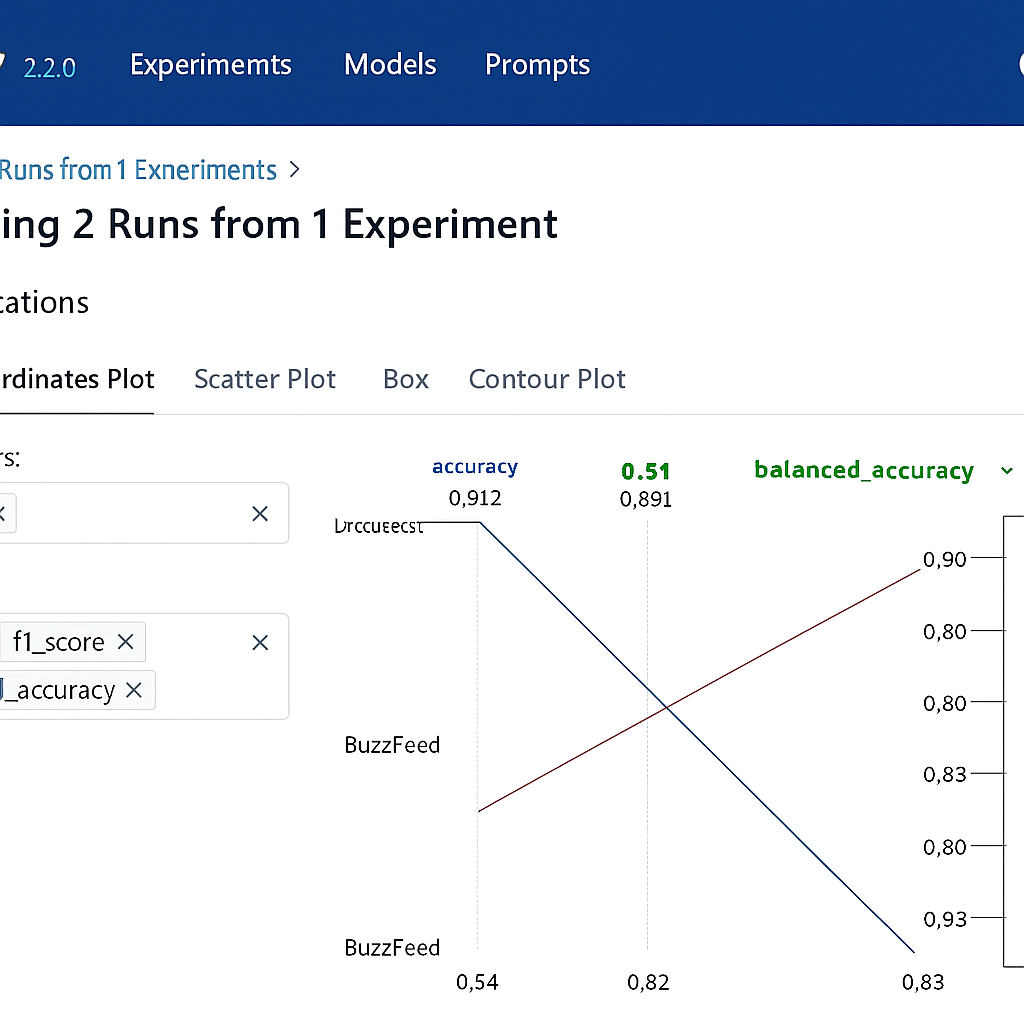